# Random Forest Regressor for Kaggle New York City Taxi Fare Prediction [competition](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)

## Imports

In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
import numpy as np
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.ensemble import forest

import matplotlib.pyplot as plt
import seaborn as sns

import IPython
from IPython.display import display
import graphviz

from datetime import datetime
import math
import re

import os

## The Data

The training data for this competition is 55M rows, each representing a taxi trip in New York City. Our goal is to use the data to provide a fare prediction to the rider based on the pickup time, number of passengers, and the pickup and dropoff locations. 

**NOTE:** Due to the constraints of the problem statement, we must be careful not to pull in external data that we would not reasonably expect to have access to at the beginning of the taxi ride in training our model.

### Import the Data

In [8]:
PATH = "./" # relative path to our data
!dir {PATH}

Invalid switch - "".


In [9]:
n = 100 # load every nth row into df_raw

%time df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False, skiprows=lambda i: i % n != 0)

Wall time: 2min 50s


### Initial data inspection

In [10]:
df_raw.shape # this gives us about half a million rows, plent for quick prototyping

(554238, 8)

In [11]:
df_raw.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2011-06-09 00:53:00.00000066,5.7,2011-06-09 00:53:00 UTC,-73.983052,40.722588,-73.988022,40.733738,3
1,2013-01-05 21:36:00.000000198,5.5,2013-01-05 21:36:00 UTC,-73.989692,40.735497,-73.982012,40.739392,1
2,2015-04-18 08:29:08.0000002,11.5,2015-04-18 08:29:08 UTC,-73.955116,40.768990,-73.984238,40.748440,1
3,2009-09-02 05:18:10.0000001,25.7,2009-09-02 05:18:10 UTC,-73.991729,40.760501,-73.861246,40.767619,1
4,2012-11-30 11:02:00.000000111,38.8,2012-11-30 11:02:00 UTC,-73.974620,40.756922,-73.864002,40.767872,1


In [12]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554238 entries, 0 to 554237
Data columns (total 8 columns):
key                  554238 non-null object
fare_amount          554238 non-null float64
pickup_datetime      554238 non-null object
pickup_longitude     554238 non-null float64
pickup_latitude      554238 non-null float64
dropoff_longitude    554231 non-null float64
dropoff_latitude     554231 non-null float64
passenger_count      554238 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 33.8+ MB


In [13]:
df_raw.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,554238.000000,554238.000000,554238.000000,554231.000000,554231.000000,554238.000000
mean,11.355953,-72.488683,39.906692,-72.484505,39.919803,1.684964
std,9.740348,12.628182,10.126431,13.564444,8.976176,1.337053
min,-60.000000,-2608.756585,-3240.610495,-3341.375685,-1188.174022,0.000000
25%,6.000000,-73.992042,40.734942,-73.991392,40.734060,1.000000
50%,8.500000,-73.981773,40.752652,-73.980155,40.753192,1.000000
75%,12.500000,-73.967046,40.767143,-73.963668,40.768120,2.000000
max,315.000000,3456.222598,2209.220368,3456.222598,3313.673038,208.000000


We immidiately see few problems with the data that need to be addressed:
1. The minimum fare_amount is -60. We expect it to be a positive number.
2. Our latitudes and longitudes for both pickupp and dropoff have some obviously non-sensical values at the extremes.
3. I'm reasonably certain a cab can't hold 218 passengers. Let's set a limit of 10.

Let's just get rid of these data points.

In [14]:
print(f'Old size: {len(df_raw)}')

min_fare = 0
max_pass = 10
lat_range = [30, 50]
lon_range = [-85, -65]

df_raw = df_raw[(df_raw.pickup_latitude > lat_range[0]) & 
                (df_raw.pickup_latitude < lat_range[1]) & 
                (df_raw.pickup_longitude > lon_range[0]) & 
                (df_raw.pickup_longitude < lon_range[1]) &
                (df_raw.dropoff_latitude > lat_range[0]) & 
                (df_raw.dropoff_latitude < lat_range[1]) & 
                (df_raw.dropoff_longitude > lon_range[0]) & 
                (df_raw.dropoff_longitude < lon_range[1]) & 
                (df_raw.fare_amount > min_fare) & 
                (df_raw.passenger_count < max_pass)]
print(f'New size: {len(df_raw)}')

Old size: 554238
New size: 542624


That took off a little over 10,000 entries!

In [15]:
df_raw.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,542624.000000,542624.000000,542624.000000,542624.000000,542624.000000,542624.000000
mean,11.334894,-73.975195,40.750989,-73.974358,40.751282,1.684459
std,9.648467,0.047688,0.040032,0.045290,0.041068,1.307485
min,0.010000,-84.489890,33.844160,-84.489872,33.844167,0.000000
25%,6.000000,-73.992249,40.736586,-73.991585,40.735605,1.000000
50%,8.500000,-73.982072,40.753368,-73.980614,40.753912,1.000000
75%,12.500000,-73.968277,40.767570,-73.965377,40.768416,2.000000
max,315.000000,-65.396312,49.466667,-65.396312,48.416667,6.000000


## Pre-processing

### Distance feature engineering

In [16]:
# create two new features representing the latitude and longitude vectors traversed during the trip
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(df_raw)

In [17]:
# distance – in units of degrees – travelled during each trip
def add_distance_feature(df):
    df['distance'] = np.sqrt(df.abs_diff_longitude**2 + df.abs_diff_latitude**2)
    
add_distance_feature(df_raw)

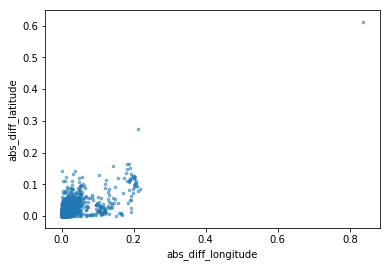

In [18]:
plot = df_raw.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude', alpha=0.5, s=7)

Let's take a quick look at the distribution for both distance travelled and taxi fare within a limited range. These limits will help us better see the shape of the distribution.

Text(0.5,1,'Taxi Ride Distance Distribution')

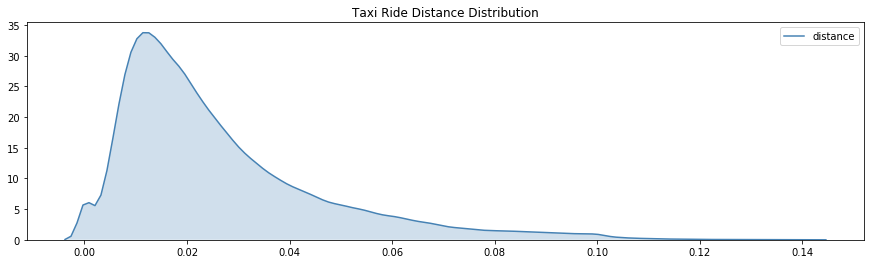

In [19]:
short_rides = df_raw[(df_raw['abs_diff_latitude'] < 0.1) & (df_raw['abs_diff_longitude'] < 0.1)]

# Kernel Density Plot for distance travelled 
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(short_rides.distance , color='steelblue',shade=True,label='distance')
plt.title('Taxi Ride Distance Distribution')

The distance travelled follows a positive skewed normal distribution, with the max frequency at less than 0.02 degrees (about 1.4 miles). This makes intuitive sense. We'd expect most rides in NYC to be short, likely within Manhattan, with a few longer rides.

Text(0.5,1,'Taxi Ride Fare')

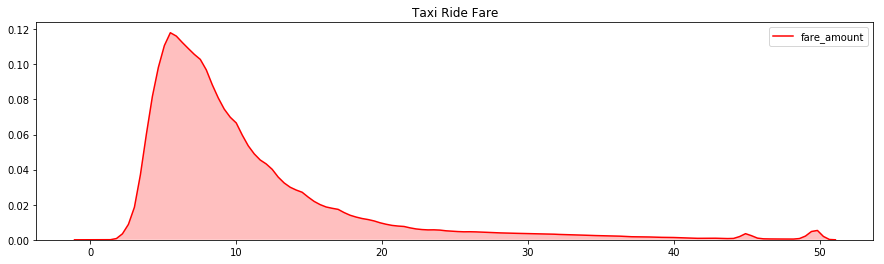

In [20]:
cheap_rides = df_raw[df_raw.fare_amount < 50]

# Kernel Density Plot for taxi fare
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(cheap_rides.fare_amount , color='red',shade=True,label='fare_amount')
plt.title('Taxi Ride Fare')

Not surprisingly, taxi fares follow a very similar distribution. We'd expect the two to be highly correlated.

In [21]:
print("Correlation between taxi fare and distance travelled: "+
      f"{df_raw['fare_amount'].corr(df_raw['distance'])}")

Correlation between taxi fare and distance travelled: 0.6574225913460322


We see that the taxi fare has a high positive correlation with distance travelled. Generally speaking, longer rides are likely to cost more. Shocker!

## Random Forests

### Quick Baseline Model

In [22]:
X_train = df_raw.drop(['key', 'pickup_datetime', 'fare_amount'], axis=1)
y_train = df_raw.fare_amount

m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
m.score(X_train, y_train)

Wall time: 49.4 s


0.9637249323731889

Our quick and dirty Random Forest model has an $R^2$ of 0.96. However, this isn't as impressive a feat as it might seem. First, let's see how it does on our test data.

In [23]:
test_raw = pd.read_csv(f'{PATH}test.csv')
test_raw.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [24]:
test_raw.shape

(9914, 7)

In [25]:
test_raw.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


Here we run into a problem. Our test data set doesn't actually contain the fare amounts and so we'd have to do one of two things:
1. Test our model by submitting to Kaggle. This will give us an RMSE, not an $R^2$.
2. Hold out a small portion of our training set as a validation set, retrain our model, and test it on the validation set.

Let's do the latter.

In [26]:
def split_vals(df, n): return df[:n].copy(), df[n:].copy()

n_valid = 9914  # same as Kaggle's test set size
n_trn = len(X_train)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(X_train, n_trn)
y_train, y_valid = split_vals(y_train, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((532710, 8), (532710,), (9914, 8), (9914,))

In [27]:
m = RandomForestRegressor()
m.fit(X_train, y_train)
m.score(X_train, y_train)

0.9637048778302889

In [28]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [29]:
print_score(m)

[1.8377565248243208, 4.354215717008818, 0.9637048778302889, 0.8009513752039636]


While this simple, no-brainer Random Forest isn't doing a terrible job on our validation set, we could do better. The drop in $R^2$ from training to validation means that we are seriously overfitting our data. Also, if you think about it, an RMSE of \$4.31 on a taxi fare prediction is rather high!

To reiterate, we'd like to be able to beat our **baseline RF Regressor $R^2$ of 0.80**.

### Bagging

Our Random Forest already uses a technique called bagging of multiple trees to give us more generalizable results. To understand what this does, let's take a look at what a single tree with no bagging looks like.

#### Use a Subset
We don't really need all 500k rows at this stage and can afford to use a small subset of this data for prototyping

In [30]:
df_sub = raw_train.sample(40000)
X_sub = df_sub.drop(['key', 'pickup_datetime', 'fare_amount'], axis=1)
y_sub = df_sub.fare_amount

In [31]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_sub, y_sub)
m.score(X_valid, y_valid)

Wall time: 1.95 s


0.7978863109046394

Using a 40,000 row sample of our training set and testing it on the same validation set gives only a small drop in $R^2$. Let's rename our subsets so we can use the print_score function on them, which takes X_train and y_train.

In [32]:
X_train = X_sub
y_train = y_sub

print_score(m)

[1.9884739835158631, 4.38761199346527, 0.9572188378584268, 0.7978863109046395]


#### Single Tree

In [33]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[4.770307366802747, 4.857619543714557, 0.753790119433378, 0.7522656128902856]


In [34]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

In [35]:
draw_tree(m.estimators_[0], X_train, precision=3)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

That's not a bad $R^2$!

Most of our splits so far are on distance, telling us that from the data available, distance appears to be by some margin the most predictive of the features available. Engineering that feature appears to have been a good decision. While the RF would have made an insight along these lines by splitting on locations instead, having the distance feature available reduces the number of splits necessary.

To draw more complex insights, if they exist, we would have to do some more feature engineering.

#### Bagged Trees

First, let's go back to our baseline model, which is a forest of randomly bagged trees.

In [36]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.9103405433376643, 4.384645595287253, 0.960514800447495, 0.798159510543412]


In [37]:
y_valid.values[0]

9.0

In [38]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0])

(array([ 8. , 10.5,  7.5,  7.3, 16. , 10. ,  7.7,  5.7, 13. ,  7.3]),
 9.299999999999999)

Each of our 10 trees – `sklearn` calls them etimators – makes its own (not great) prediction. The mean of these predictions, however, is close to much closer to our known fare value of 9.0 than the individual predictions themselves. This averaging of trees is called bagging.

In [39]:
preds.shape

(10, 9914)

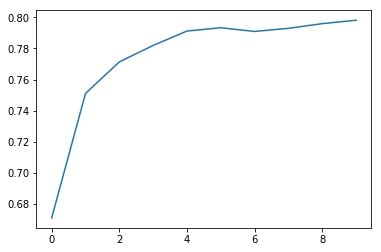

In [40]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

This plot suggests that increasing the number of trees beyond 8 or 10 won't help us much. Let's take a look for ourselves.

In [41]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.7777155249888899, 4.3354953900905855, 0.9658069940490203, 0.8026592580099086]


In [42]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.7138505680894045, 4.2203233790678665, 0.9682196513729125, 0.8130046708483949]


In [43]:
m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.6941291608157996, 4.18317615688432, 0.9689468409681993, 0.8162820434824849]


That last jump from 40 to 100 estimators made almost no difference for the accuracy of our model.

**NOTE**: You may see slightly different numbers when you run this. That's a lesson to me not to randomize how I sample my data. While not always the case, you will likely see some small increase in R^2 as you increase `n_estimators`

### Engineering Datetime Features

One of our fields is the pickup_datetime. You may have noticed that I removed this from the dataset before passing it to our model. I shall now train the same RF with the pickup_datetime. Then, I'll engineer some features from the information that this field provides us to see if that improves the model even further.

In [44]:
X_train = df_raw.drop(['key', 'fare_amount'], axis=1)
y_train = df_raw.fare_amount

n_valid = 9914  # same as Kaggle's test set size
n_trn = len(X_train)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(X_train, n_trn)
y_train, y_valid = split_vals(y_train, n_trn)

# We should now have 9 cols instead of our earlier 8.
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((532710, 9), (532710,), (9914, 9), (9914,))

In [45]:
raw_train = raw_train.sample(40000)
X_train = raw_train.drop(['key', 'fare_amount'], axis=1)
y_train = raw_train.fare_amount

X_train.shape, y_train.shape

((40000, 9), (40000,))

In [46]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

ValueError: could not convert string to float: '2014-06-24 08:23:31 UTC'

We realize now that, in fact, the Random Forest cannot even use the `pickup_datetime` field in this form since it is a string. This field is of no use to us without some feature engineering. Let's do that and then remove the pickup_datetime field from our dataset.

In [47]:
def add_datetime_features(df):
    
    year = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z" ).year
    df['year'] = df['pickup_datetime'].map(year)
    print('1/7')
    
    hour = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z" ).hour
    df['hour'] = df['pickup_datetime'].map(hour)
    print('2/7')

    day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z" ).weekday()
    df['day_of_week'] = df['pickup_datetime'].map(day_of_week)
    print('3/7')

    month = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z" ).month
    df['month'] = df['pickup_datetime'].map(month)
    print('4/7')

    week_number = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z" ).strftime('%V')
    df['week_number'] = df['pickup_datetime'].map(week_number)
    print('5/7')
    
    seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
    season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z" ).month-1)]
    df['season'] = df['pickup_datetime'].map(season)
    print('6/7')
    
    # 10pm-5am is late-night
    late_night_hours = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
    late_night = lambda x: late_night_hours[(datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z" ).hour)]
    df['late_night'] = df['pickup_datetime'].map(late_night)
    print('7/7. All done!')
    
add_datetime_features(df_raw)

1/7
2/7
3/7
4/7
5/7
6/7
7/7. All done!


In [48]:
df_raw.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,hour,day_of_week,month,week_number,season,late_night
0,2011-06-09 00:53:00.00000066,5.7,2011-06-09 00:53:00 UTC,-73.983052,40.722588,-73.988022,40.733738,3,0.004970,0.011150,0.012208,2011,0,3,6,23,2,1
1,2013-01-05 21:36:00.000000198,5.5,2013-01-05 21:36:00 UTC,-73.989692,40.735497,-73.982012,40.739392,1,0.007680,0.003895,0.008611,2013,21,5,1,01,0,0
2,2015-04-18 08:29:08.0000002,11.5,2015-04-18 08:29:08 UTC,-73.955116,40.768990,-73.984238,40.748440,1,0.029121,0.020550,0.035642,2015,8,5,4,16,1,0
3,2009-09-02 05:18:10.0000001,25.7,2009-09-02 05:18:10 UTC,-73.991729,40.760501,-73.861246,40.767619,1,0.130483,0.007118,0.130677,2009,5,2,9,36,3,1
4,2012-11-30 11:02:00.000000111,38.8,2012-11-30 11:02:00 UTC,-73.974620,40.756922,-73.864002,40.767872,1,0.110618,0.010950,0.111159,2012,11,4,11,48,3,0


In [49]:
X_train = df_raw.drop(['key', 'fare_amount', 'pickup_datetime'], axis=1)
y_train = df_raw.fare_amount

X_train, X_valid = split_vals(X_train, n_trn)
y_train, y_valid = split_vals(y_train, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((532710, 15), (532710,), (9914, 15), (9914,))

In [50]:
df_sub = df_raw.sample(40000)

In [51]:
X_train = df_sub.drop(['key', 'pickup_datetime', 'fare_amount'], axis=1)
y_train = df_sub.fare_amount

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((40000, 15), (40000,), (9914, 15), (9914,))

In [52]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.9287235940707006, 3.948123917498556, 0.9607912115158106, 0.8363481762202127]


In [53]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.7161561345125336, 3.8935100678624486, 0.9689574756197507, 0.8408444076478585]


While we're doing noticeably better in terms of validation R^2, our biggest problem is still that we're overfitting drastically on the training data. The model simply isn't generalizing. 

I borrowed a function called `set_rf_samples` from the fastai library to help combat this. Instead of sampling our training data up-front like scikit-learn does and then averaging together several `estimators` trained on that data, we could choose a different random subsample for each tree. This way, they don't have the opportunity to fit the whole training set as closely.

In [54]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [55]:
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [56]:
df_raw.shape

(542624, 18)

We'll have to return to our full dataset to see this technique in action.

In [57]:
X_train = df_raw.drop(['key', 'fare_amount', 'pickup_datetime'], axis=1)
y_train = df_raw.fare_amount

X_train, X_valid = split_vals(X_train, n_trn)
y_train, y_valid = split_vals(y_train, n_trn)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((532710, 15), (532710,), (9914, 15), (9914,))

In [58]:
set_rf_samples(20000)

In [59]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 4.39 s
[3.971906363183354, 3.892617092500612, 0.8304607260502851, 0.8409174038504472]


In [60]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[3.832048171295845, 3.8579519214954856, 0.8421901033291217, 0.8437381644834817]


You'll notice that our model performs about the same on the training and validation data now, a sign isn't overfit and that it generalizes well to new observations. What's more, we didn't lose any predictive power in the process and still have an R^2 of 0.84

However, the most impressive part is that we did all this without any hyperparameter tuning! A `RandomForestRegressor` with all the defaults (coupled with a few techniques to ensure our model generalizes and some feature engineering) can predict the fare of a taxi using not much more than pickup and dropoff locations and pickup time. It does so with an RMSE of less than 4 dollars, which is not too bad considering our mean fare amount is over 11 dollars.

A real-world model to do something like that is likely to gain a fair bit of predictive accuracy from access to real time traffic flow and routing information. While walking through the hyperparameter tuning process is beyond the scope of this notebook, suffice it to say for now that tweaking some of these defaults can increase performance a little. I will however change the number of subsamples we choose for each tree to see if that helps our accuracy.

In [61]:
set_rf_samples(50000)

In [62]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 8.51 s
[3.734104132604194, 3.98028824088565, 0.8501539960867236, 0.8336708583421382]


It did! This process might seem like a bit of trial and error, and it is. That said, if you're interested, `sklearn.model_selection.RandomizedSearchCV` and `sklearn.model_Selection.GridSearchCV` are useful tools to help automate this process to varying degrees (possibly at the cost of extra computational expense).

In [63]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 28.6 s
[3.550521123436166, 3.726188312754013, 0.8645258242300314, 0.8542297502374774]


Having trained a model with R^2 about 0.05 greater than our baseline and a validation RMSE that's better by just over 60c, let's get predictions on the test data and write them to a submission file that meets Kaaggle's specifications for the competition.

In [64]:
test_raw = pd.read_csv(f'{PATH}test.csv')

In [65]:
test_raw.shape
test_raw.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [66]:
add_travel_vector_features(test_raw)
add_distance_feature(test_raw)
add_datetime_features(test_raw)

test_raw.head()

1/7
2/7
3/7
4/7
5/7
6/7
7/7. All done!


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,hour,day_of_week,month,week_number,season,late_night
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,0.008110,0.019970,0.021554,2015,13,1,1,05,0,0
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,0.012024,0.019817,0.023180,2015,13,1,1,05,0,0
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,0.002870,0.005121,0.005870,2011,11,5,10,40,3,0
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,0.009288,0.016172,0.018649,2012,21,5,12,48,0,0
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,0.022519,0.045348,0.050631,2012,21,5,12,48,0,0


In [67]:
X_test = test_raw.drop(['pickup_datetime', 'key'], axis=1)
X_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,distance,year,hour,day_of_week,month,week_number,season,late_night
0,-73.973320,40.763805,-73.981430,40.743835,1,0.008110,0.019970,0.021554,2015,13,1,1,05,0,0
1,-73.986862,40.719383,-73.998886,40.739201,1,0.012024,0.019817,0.023180,2015,13,1,1,05,0,0
2,-73.982524,40.751260,-73.979654,40.746139,1,0.002870,0.005121,0.005870,2011,11,5,10,40,3,0
3,-73.981160,40.767807,-73.990448,40.751635,1,0.009288,0.016172,0.018649,2012,21,5,12,48,0,0
4,-73.966046,40.789775,-73.988565,40.744427,1,0.022519,0.045348,0.050631,2012,21,5,12,48,0,0


In [68]:
X_test.shape

(9914, 15)

In [69]:
y_pred = m.predict(X_test)

In [70]:
# Write the predictions to a CSV file which we can submit to the competition.
RF_submission2 = pd.DataFrame(
    {'key': test_raw.key, 'fare_amount': y_pred},
    columns = ['key', 'fare_amount'])
RF_submission2.to_csv('RF_submission.csv', index = False)

print(os.listdir('.'))

['.ipynb_checkpoints', 'nycTaxi_rf.ipynb', 'README.md', 'RF_submission.csv', 'sample_submission.csv', 'test.csv', 'train.csv']
